# Initial setups

In [1]:
using JuMP
using Gurobi
env = Gurobi.Env()

using Plots

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


# Branch swityching only - general case

# model

## DC PF

In [118]:
struct Branch
    b::Float64
    p_max::Float64
    v_nom1::Float64
    v_nom2::Float64
    p::Float64
    Branch(b, p_max) = new(b, p_max, 0, 0, 0)
    Branch(b, p_max, v_nom1, v_nom2) = new(b, p_max, v_nom1, v_nom2, 0)
    Branch(b::Branch) = new(b.b, b.p_max, b.v_nom1, b.v_nom2, b.p)
    Branch(b::Branch, p_max) = new(b.b, p_max, b.v_nom1, b.v_nom2, b.p)
end

struct BranchId
    bus1
    bus2
end

function init_model()
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)
    model
end

function init_dc(model, p_buses, slack_id = nothing)
    slack_id = slack_id == nothing ? argmax(p_buses) : slack_id
    model.ext[:slack_id] = slack_id

    @variable(model, model[:model[:θ]][bus in keys(p_buses)])
    @constraint(model, slack, θ[slack_id] == 0)
end

function dc_pf(p_buses, branches, slack_id = nothing)
    model = init_model()
    init_dc(model, p_buses, branches, slack_id)

    @variable(model, flows[br in keys(branches)])

    #bus balance constraint
    @constraint(model, bus_balance_constraint[bus in keys(p_buses); bus ≠ slack_id],
        p_buses[bus] + sum(flows[br] for br in keys(branches) if bus == br.bus1)
                     - sum(flows[br] for br in keys(branches) if bus == br.bus2) == 0)

    @constraint(model, flow_constraint[br in keys(branches)],
        branches[br].b * (model[:θ][br.bus2] - model[:θ][br.bus1]) == flows[br])
    model
end

dc_pf (generic function with 2 methods)

In [117]:
branches = Dict([
            (BranchId("0", "1") => Branch(1, 1)),
            (BranchId("1", "2") => Branch(1, 1)),
            (BranchId("0", "2") => Branch(1, 1))])
p_buses = Dict([("0" => 0), ("1" => -2), ("2" => -1)])

model = dc_pf(p_buses, branches, "0")
optimize!(model)
# println(solution_summary(model))
for v in all_variables(model)
    println("$v = $(value(v))")
end
latex_formulation(model)


θ[1] = -1.6666666666666667
θ[0] = 0.0
θ[2] = -1.3333333333333335
flows[BranchId("0", "1")] = -1.6666666666666667
flows[BranchId("1", "2")] = 0.33333333333333337
flows[BranchId("0", "2")] = -1.3333333333333335


$$ \begin{aligned}
\text{feasibility}\\
\text{Subject to} \quad & θ_{0} = 0\\
 & -flows_{BranchId("0", "1")} + flows_{BranchId("1", "2")} = 2\\
 & -flows_{BranchId("1", "2")} - flows_{BranchId("0", "2")} = 1\\
 & θ_{1} - θ_{0} - flows_{BranchId("0", "1")} = 0\\
 & -θ_{1} + θ_{2} - flows_{BranchId("1", "2")} = 0\\
 & -θ_{0} + θ_{2} - flows_{BranchId("0", "2")} = 0\\
\end{aligned} $$

## DC OTS

In [130]:
function dc_ots(p_buses, branches, slack_id = nothing)
    model = init_model()
    init_dc(model, p_buses, branches, slack_id)

    bigM= 1e3
    @variable(model, flows[br in keys(branches)], lower_bound = -branches[br].p_max, upper_bound = branches[br].p_max)
    @variable(model, ls[bus in keys(p_buses); bus ≠ model.ext[:slack_id]], lower_bound = 0, upper_bound = max(0, - p_buses[bus]))
    @variable(model, sw[br in keys(branches)], Bin)

    @constraint(model, close_le[br in keys(branches)],
        flows[br] - branches[br].b * (model[:θ][br.bus1] - model[:θ][br.bus2]) - (1 - sw[br]) * bigM ≤ 0)
    @constraint(model, close_ge[br in keys(branches)],
        flows[br] - branches[br].b * (model[:θ][br.bus1] - model[:θ][br.bus2]) + (1 - sw[br]) * bigM ≥ 0)
    @constraint(model, open_le[br in keys(branches)], flows[br] - sw[br] * bigM ≤ 0)
    @constraint(model, open_ge[br in keys(branches)], flows[br] + sw[br] * bigM ≥ 0)
    @constraint(model, length(keys(branches)) - sum(sw) ≤ 6)

    #bus balance constraint
    @constraint(model, bus_balance_constraint[bus in keys(p_buses); bus ≠ model.ext[:slack_id]],
        p_buses[bus] + ls[bus] + sum(flows[br] for br in keys(branches) if bus == br.bus1)
                     - sum(flows[br] for br in keys(branches) if bus == br.bus2) == 0)

    @objective(model, Min, sum(ls) - sum(sw) / 100)

    model
end

dc_ots (generic function with 2 methods)

In [131]:
branches = Dict([
            (BranchId("0", "1") => Branch(1, 3)),
            (BranchId("1", "2") => Branch(1, 3)),
            (BranchId("0", "2") => Branch(1, 3))])
p_buses = Dict([("0" => 0), ("1" => -1), ("2" => -2)])
model = dc_ots(p_buses, branches, "0")
optimize!(model)
# println(model)
# println(solution_summary(model))
for v in all_variables(model)
    println("$v: $(value(v))")
end

θ[1]: 1.3333333333333333
θ[0]: 0.0
θ[2]: 1.6666666666666667
flows[BranchId("0", "1")]: -1.3333333333333333
flows[BranchId("1", "2")]: -0.3333333333333333
flows[BranchId("0", "2")]: -1.6666666666666667
ls[1]: 0.0
ls[2]: 0.0
sw[BranchId("0", "1")]: 1.0
sw[BranchId("1", "2")]: 1.0
sw[BranchId("0", "2")]: 1.0


In [205]:
using Random
using GraphRecipes
using Plots
using LightGraphs

function grid_to_graphplot(p_buses::Dict{String, Int64}, branches::Dict{BranchId, Branch}, model::Union{Model, Nothing} = nothing, figsize::Tuple{Int64, Int64} = (1000, 600), fontsize::Int64 = 5)
    Random.seed!(42)
    buses = keys(p_buses) |> collect |> sort
    dim = size(buses)[1]
    A = zeros(dim, dim)
    edgecolors = Dict()
    edgeweights = Dict()
    edgelabel = Dict()
    for branch in keys(branches)
        i, j = [branch.bus1, branch.bus2] .|> x->findfirst(==(x), buses)
        if model ≠ nothing
            flow = value(model[:flows][branch])
            p_max = branches[branch].p_max
            if haskey(model,:sw)
                edgecolors[(i, j)] = value(model[:sw][branch]) == 0 ? :black : 
                    abs(flow) ≤ p_max ? :green : :red
            else
                edgecolors[(i, j)] = abs(flow) ≤ p_max ? :green : :red
            end
            edgecolors[(j, i)] = edgecolors[(i,j)]
            edgeweights[(i, j)] = abs(flow) * 1 + 1
            edgeweights[(j, i)] = edgeweights[(i,j)]
            edgelabel[(i, j)] = round(abs(flow), digits = 2)
            edgelabel[(j, i)] = edgelabel[(i, j)] 
            if flow < 0
                A[i, j] = 1
            else
                A[j, i] = 1
            end
        else
            A[i, j] = 1
            A[j, i] = 1
        end
    end

    p = [p_buses[bus] for bus in buses]

    if model == nothing
        graphplot(A,
                curves = false,
                names = buses,
                node_weights = ["$bus($(p_buses[bus]))" for bus in buses],
                nodecolor = :white,
                nodeshape = p .|> x->x > 0 ? :rect : :circle)
    else
        if haskey(model, :ls)
            ls = Dict([bus => (haskey(model[:ls], bus) ? value(model[:ls][bus]) : 0) for bus in buses])
            nodecolor = [ls[bus] == 0 ? :lightblue : :red for bus in buses]
            node_weights = [abs(p_buses[bus]) + 1 - ls[bus] for bus in buses]
            names = ["$bus($(p_buses[bus] + ls[bus]))" for bus in buses]
        else
            nodecolor = [:lightblue for bus in buses]
            node_weights = (@. abs(p) + 1)
            names = ["$bus($(p_buses[bus]))" for bus in buses]
        end

    graphplot(A, size = figsize,
                curves = false,
                fontsize = fontsize,
                edgecolor = edgecolors,
                edgelabel = edgelabel,
                edgewidth = (s, d, w) -> edgeweights[s, d],
                names = names,
                node_weights = node_weights,
                nodecolor = nodecolor,
                nodeshape = p .|> x->x > 0 ? :rect : :circle)
    end
end

grid_to_graphplot (generic function with 4 methods)

In [162]:
branches = Dict([
            (BranchId("1", "2") => Branch(1, 1)),
            (BranchId("2", "3") => Branch(1, 1)),
            (BranchId("1", "3") => Branch(1, 1)),
            (BranchId("4", "5") => Branch(1, 1)),
            (BranchId("5", "3") => Branch(1, 1)),
            (BranchId("4", "3") => Branch(1, 1))])
p_buses = Dict([("1" => 1),
                ("2" => -1),
                ("3" => 0),
                ("4" => 2),
                ("5" => -3)])
model_pf = dc_pf(p_buses, branches, "1")
optimize!(model_pf)
model_ots = dc_ots(p_buses, branches, "1")
optimize!(model_ots)
# println(model)
# println(solution_summary(model))
for v in all_variables(model)
    println("$v: $(value(v))")
end

θ[1]: 1.3333333333333333
θ[0]: 0.0
θ[2]: 1.6666666666666667
flows[BranchId("0", "1")]: -1.3333333333333333
flows[BranchId("1", "2")]: -0.3333333333333333
flows[BranchId("0", "2")]: -1.6666666666666667
ls[1]: 0.0
ls[2]: 0.0
sw[BranchId("0", "1")]: 1.0
sw[BranchId("1", "2")]: 1.0
sw[BranchId("0", "2")]: 1.0


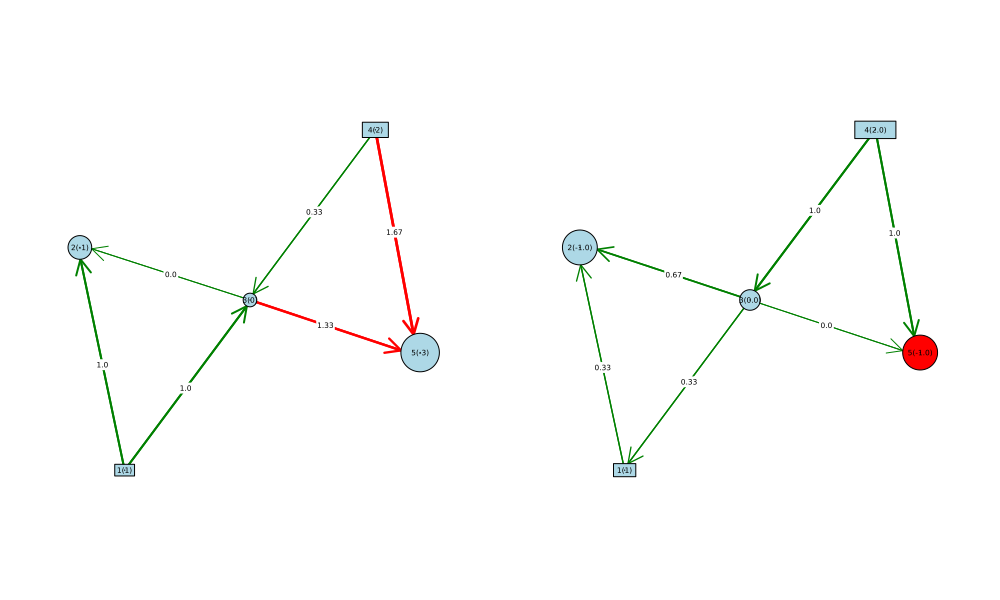

In [207]:
layout = (1,2)
g1 = grid_to_graphplot(p_buses, branches, model_pf)
g2 = grid_to_graphplot(p_buses, branches, model_ots)
plot(g1, g2, layout = (1,2))

# display(model[:flows] .|>value)

In [9]:
methods(grid_to_graphplot)


# 4 methods for generic function "grid_to_graphplot" from Main:
 [1] grid_to_graphplot(p_buses::Dict{String, Int64}, branches::Dict{BranchId, Branch})
     @ ~/vsCode/TUD/topo_sandbox/juliatest.ipynb:6
 [2] grid_to_graphplot(p_buses::Dict{String, Int64}, branches::Dict{BranchId, Branch}, model::Union{Nothing, Model}, figsize::Tuple{Int64, Int64}, fontsize::Int64)
     @ ~/vsCode/TUD/topo_sandbox/juliatest.ipynb:6
 [3] grid_to_graphplot(p_buses::Dict{String, Int64}, branches::Dict{BranchId, Branch}, model::Union{Nothing, Model}, figsize::Tuple{Int64, Int64})
     @ ~/vsCode/TUD/topo_sandbox/juliatest.ipynb:6
 [4] grid_to_graphplot(p_buses::Dict{String, Int64}, branches::Dict{BranchId, Branch}, model::Union{Nothing, Model})
     @ ~/vsCode/TUD/topo_sandbox/juliatest.ipynb:6

In [10]:
typeof(model)

Model (alias for GenericModel{Float64})

In [63]:
haskey(model_pf, :sw)


false